In [1]:
import pandas as pd
from datetime import datetime

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [2]:
# NASDAQ Composite (^IXIC)
# Dow Jones Industrial Average (^DJI)
# S&P 500 (^GSPC)
# Russell 2000 Index (^RUT)
# tickers = ['^IXIC', '^DJI', '^GSPC', '^RUT']

In [3]:
# tickers = ['NVDA', 'GOOGL', 'AAPL', 'MSFT', 'AMZN', 'META', 'TSLA', 'NFLX', 'WMT', 'V', 'PFE', 'RACE']

In [4]:
# tickers = ['EURUSD=X', 'GBPUSD=X', 'USDCAD=X', 'USDCHF=X', 'EURGBP=X', 'AUDUSD=X', 'NZDUSD=X', 'EURCAD=X', 'EURCHF=X', 'GBPCHF=X']

In [5]:
# tickers = ['GC=F', 'SIL=F']

In [6]:
tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'DOGE-USD', 'LTC-USD', 'ADA-USD']

In [ ]:
# # Download historical data from yf API
# df = yf.download(tickers, period='max', group_by='ticker', interval='1d')

# # download data to csv, with tickers as a name
# df.to_csv(f"{'_'.join(tickers)}_D_data.csv")

[*********************100%***********************]  8 of 8 completed


In [8]:
# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv(f"{'_'.join(tickers)}_D_data.csv", header=[0,1], index_col=0)

# Show the result
df.head()

Ticker     SOL-USD                       XRP-USD                        ...  \
Price         Open High Low Close Volume    Open High Low Close Volume  ...   
Date                                                                    ...   
2014-09-17     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   
2014-09-18     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   
2014-09-19     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   
2014-09-20     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   
2014-09-21     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN  ...   

Ticker     ADA-USD                        LTC-USD                             \
Price         Open High Low Close Volume     Open     High      Low    Close   
Date                                                                           
2014-09-17     NaN  NaN NaN   NaN    NaN  5.08589  5.17077  4.96595  5.05855   
2014-09-18     NaN  NaN NaN   NaN    NaN  5.06543  5.06543  4.57996  4.68523   
2014-09-19     NaN  NaN NaN   NaN    NaN  4.68729  4.75582  4.25435  4.32777   
2014-09-20     NaN  NaN NaN   NaN    NaN  4.32920  4.61608  4.20219  4.28644   
2014-09-21     NaN  NaN NaN   NaN    NaN  4.26307  4.30013  4.15499  4.24592   

Ticker               
Price        Volume  
Date                 
2014-09-17  3071840  
2014-09-18  4569260  
2014-09-19  3917450  
2014-09-20  5490660  
2014-09-21  2931220  

[5 rows x 40 columns]

In [9]:
# Create dataframes for all tickers
def prepare_data(df, ticker_name, gap_threshold):
    """Helper function to prepare the data"""
    df_ = df[ticker_name]

    # Drop any rows that are completely NaN (e.g. 'Date' row)
    df_ = df_.dropna(how='all')

    # Convert all values to float
    df_ = df_.astype(float)
    
    # keep only the 'Open' and 'Close' columns
    df_ = df_[['Open', 'Close']]
    
    # columns lowercase
    df_.columns = [col.lower() for col in df_.columns]
    
    # index to datetime
    df_.index = pd.to_datetime(df_.index)
    
    # add column 'day_of_week' with the day of the week (0=Monday, 6=Sunday)
    df_['day_of_week'] = df_.index.weekday
    
    # calculate the gap percentage
    df_['gap_pct'] = ((df_['open'] - df_['close'].shift(1)) / df_['close'].shift(1)) * 100
    
    # Label the gaps: Gap Up (1), Gap Down (-1), No Gap (0)
    def label_gap(gap):
        if gap > gap_threshold:
            return 1  # Gap Up
        elif gap < -gap_threshold:
            return -1  # Gap Down
        else:
            return 0  # No Gap
    
    # drop na
    df_ = df_.dropna()
    
    df_['gap_label'] = df_['gap_pct'].apply(label_gap)
    
    return df_

# Create all ticker dataframes using a loop
ticker_dfs = {}
gap_threshold = 0.5

print("Dataframes created for:")
for ticker in tickers:
    ticker_dfs[ticker] = prepare_data(df, ticker, gap_threshold)
    print(f"- {ticker}: {ticker_dfs[ticker].shape} rows x columns")

Dataframes created for:
- BTC-USD: (4097, 5) rows x columns
- ETH-USD: (2948, 5) rows x columns
- BNB-USD: (2948, 5) rows x columns
- XRP-USD: (2948, 5) rows x columns
- SOL-USD: (2065, 5) rows x columns
- DOGE-USD: (2948, 5) rows x columns
- LTC-USD: (4097, 5) rows x columns
- ADA-USD: (2948, 5) rows x columns


In [10]:
# Comprehensive analysis function for all tickers
def analyze_gap_strategy(df_, ticker_name):
    """Analyze gap trading strategy for any index"""
    
    # Filter for gap up days only (gap_label == 1)
    gap_up_days = df_[df_['gap_label'] == 1].copy()
    
    if len(gap_up_days) == 0:
        return None, None, None
    
    # Calculate intraday return: (close - open) / open * 100
    gap_up_days['intraday_return'] = ((gap_up_days['close'] - gap_up_days['open']) / gap_up_days['open']) * 100
    
    # Group by day of the week and calculate statistics
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    strategy_results = gap_up_days.groupby('day_of_week')['intraday_return'].agg([
        'count',    # Number of gap up days
        'mean',     # Average return
        'std',      # Standard deviation
        'min',      # Worst return
        'max',      # Best return
    ]).round(4)
    
    # Calculate compounded return for each day
    def calc_compounded_return(x):
        return ((1 + x / 100).prod() - 1) * 100
    
    strategy_results['total_compounded'] = gap_up_days.groupby('day_of_week')['intraday_return'].apply(calc_compounded_return).round(4)
    
    # Add day names for better readability
    strategy_results.index = [day_names[i] for i in strategy_results.index]
    
    # Calculate win rate for each day
    win_rates = gap_up_days.groupby('day_of_week').apply(
        lambda x: (x['intraday_return'] > 0).sum() / len(x) * 100
    ).round(2)
    win_rates.index = [day_names[i] for i in win_rates.index]
    
    # Overall strategy performance
    total_trades = len(gap_up_days)
    # Correct: Compounded total return
    total_return = ((1 + gap_up_days['intraday_return'] / 100).prod() - 1) * 100
    avg_return = gap_up_days['intraday_return'].mean()
    win_rate = (gap_up_days['intraday_return'] > 0).sum() / total_trades * 100
    
    # Summary statistics
    summary = {
        'Ticker': ticker_name,
        'Total Gap Up Days': total_trades,
        'Total Return (%)': round(total_return, 2),
        'Average Return per Trade (%)': round(avg_return, 4),
        'Overall Win Rate (%)': round(win_rate, 2),
        'Best Day (Avg Return)': strategy_results['mean'].idxmax(),
        'Best Day Return (%)': round(strategy_results['mean'].max(), 4),
        'Worst Day (Avg Return)': strategy_results['mean'].idxmin(),
        'Worst Day Return (%)': round(strategy_results['mean'].min(), 4)
    }
    
    return strategy_results, win_rates, summary

# Analyze all tickers using the ticker_dfs dictionary
tickers_ = ticker_dfs  # Use the dictionary from the previous cell

all_results = {}
all_summaries = []

print("Gap Trading Strategy Analysis for All Tickers")
print("=" * 80)

for name, data in tickers_.items():
    print(f"\n{name.upper()} ANALYSIS:")
    print("-" * 50)
    
    results, win_rates, summary = analyze_gap_strategy(data, name)
    
    if results is not None:
        all_results[name] = {
            'strategy_results': results,
            'win_rates': win_rates,
            'summary': summary
        }
        all_summaries.append(summary)
        
        print(f"Total Gap Up Days: {summary['Total Gap Up Days']}")
        print(f"Total Return: {summary['Total Return (%)']}%")
        print(f"Average Return per Trade: {summary['Average Return per Trade (%)']}%") 
        print(f"Overall Win Rate: {summary['Overall Win Rate (%)']}%")
        print(f"Best Day: {summary['Best Day (Avg Return)']} ({summary['Best Day Return (%)']}%)")
        print(f"Worst Day: {summary['Worst Day (Avg Return)']} ({summary['Worst Day Return (%)']}%)")
    else:
        print(f"No gap up days found for {name}")

Gap Trading Strategy Analysis for All Tickers

BTC-USD ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 35
Total Return: 21.81%
Average Return per Trade: 0.6906%
Overall Win Rate: 54.29%
Best Day: Saturday (5.3804%)
Worst Day: Friday (-2.5338%)

ETH-USD ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 31
Total Return: 48.16%
Average Return per Trade: 1.5304%
Overall Win Rate: 61.29%
Best Day: Saturday (3.2088%)
Worst Day: Thursday (-1.1337%)

BNB-USD ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 70
Total Return: 101.79%
Average Return per Trade: 1.2105%
Overall Win Rate: 52.86%
Best Day: Thursday (4.0849%)
Worst Day: Sunday (-2.8178%)

XRP-USD ANALYSIS:
--------------------------------------------------
Total Gap Up Days: 38
Total Return: 218.83%
Average Return per Trade: 3.8533%
Overall Win Rate: 60.53%
Best Day: Friday (12.9176%)
Worst Day: Monday (-3.4483%)

SOL-USD ANALYSIS:
------------


COMPARATIVE SUMMARY - ALL TICKERS
          Total Gap Up Days  Total Return (%)  Average Return per Trade (%)  \
Ticker                                                                        
BTC-USD                  35             21.81                        0.6906   
ETH-USD                  31             48.16                        1.5304   
BNB-USD                  70            101.79                        1.2105   
XRP-USD                  38            218.83                        3.8533   
SOL-USD                  27             27.88                        1.2340   
DOGE-USD                 77            180.89                        1.6981   
LTC-USD                  96            -51.45                       -0.4873   
ADA-USD                  52            373.63                        3.5937   

          Overall Win Rate (%) Best Day (Avg Return)  Best Day Return (%)  \
Ticker                                                                      
BTC-USD             

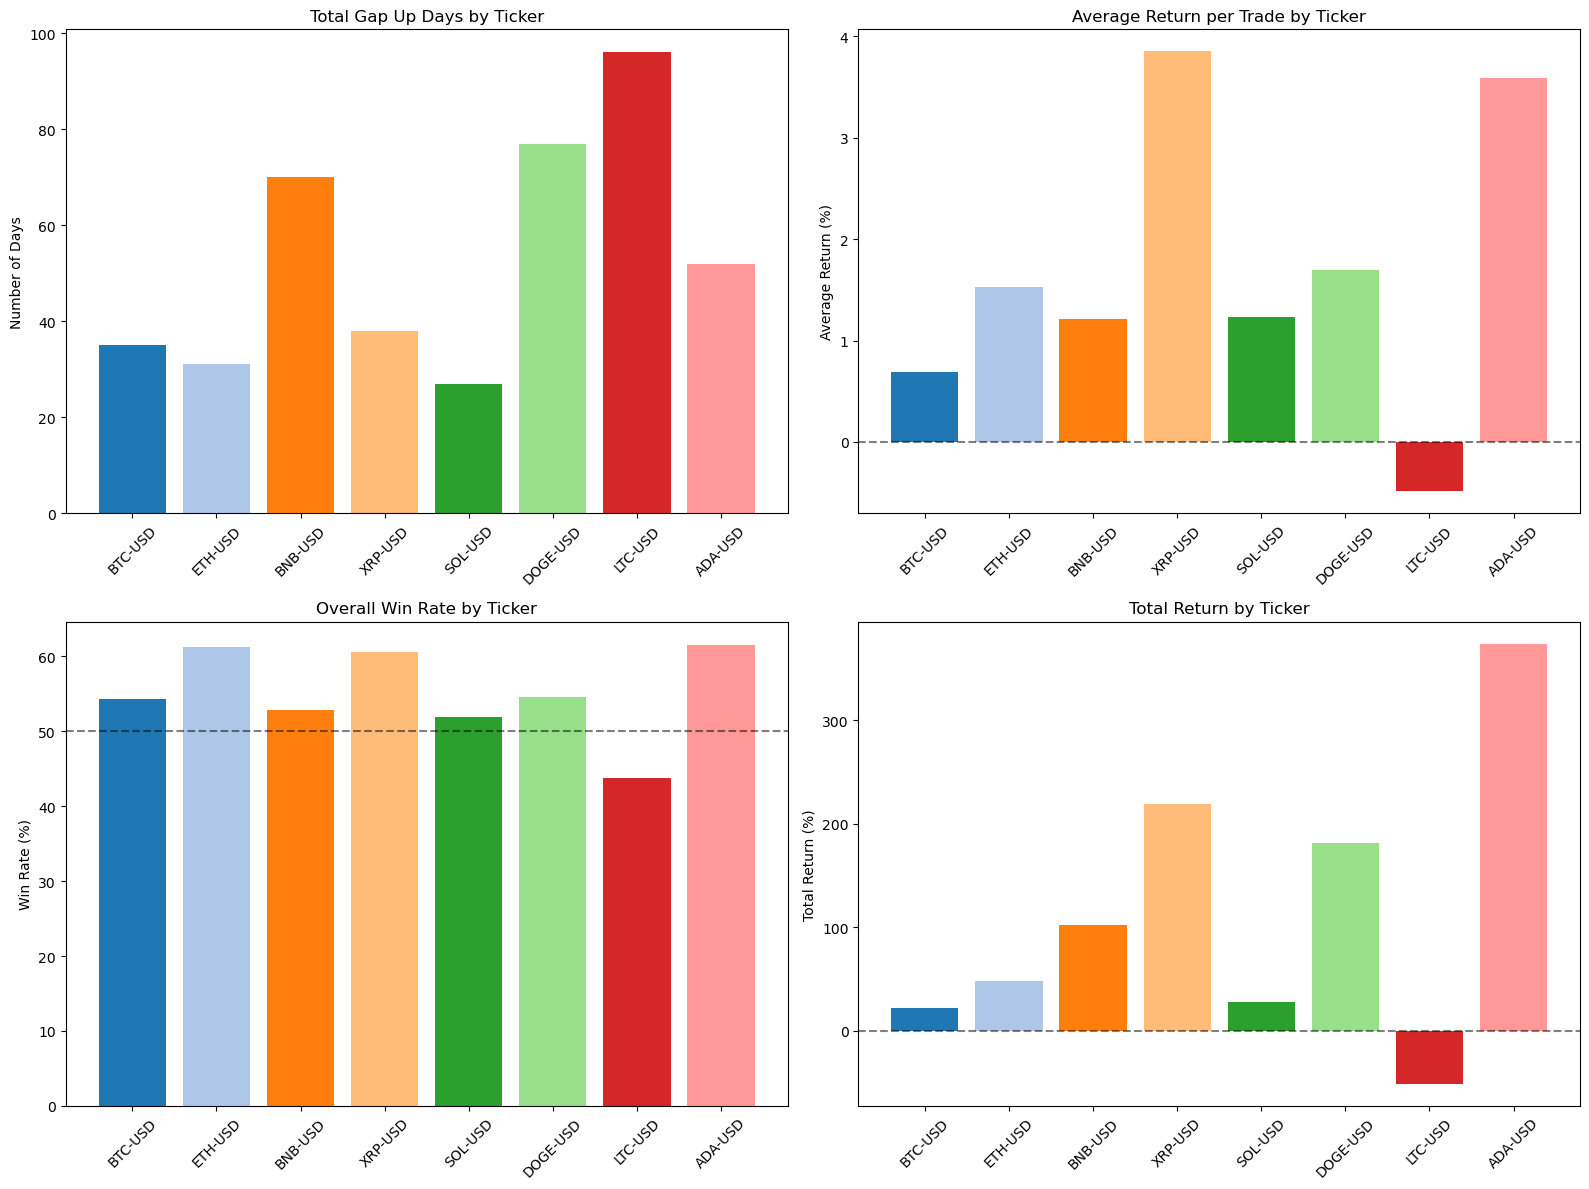


 PERFORMANCE RANKINGS:
--------------------------------------------------
Best Average Return per Trade: XRP-USD (3.8533%)
Best Win Rate: ADA-USD (61.54%)
Best Total Return: ADA-USD (373.63%)
Most Trading Opportunities: LTC-USD (96 days)
Best Risk-Adjusted Performance: XRP-USD

 STRATEGY INSIGHTS:
--------------------------------------------------
• Average gap opportunities per ticker: 53 days
• Most consistent performer (highest win rate): ADA-USD
• Highest return potential: XRP-USD
• Ticker with most gap opportunities: LTC-USD


In [11]:
import matplotlib.pyplot as plt

# Create comprehensive summary comparison
summary_df = pd.DataFrame(all_summaries)
summary_df = summary_df.set_index('Ticker')  # Changed from 'Index' to 'Ticker'

print("\n" + "=" * 100)
print("COMPARATIVE SUMMARY - ALL TICKERS")
print("=" * 100)
print(summary_df)

# Visualization comparing all tickers - dynamic number of subplots
n_tickers = len(summary_df)
n_cols = min(4, n_tickers)  # Max 4 columns
n_rows = 2

fig, axes = plt.subplots(n_rows, 2, figsize=(16, 12))

# Generate colors dynamically
colors = plt.cm.tab20(range(n_tickers))

# 1. Total Gap Up Days comparison
axes[0,0].bar(summary_df.index, summary_df['Total Gap Up Days'], color=colors)
axes[0,0].set_title('Total Gap Up Days by Ticker')
axes[0,0].set_ylabel('Number of Days')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Average Return per Trade comparison
axes[0,1].bar(summary_df.index, summary_df['Average Return per Trade (%)'], color=colors)
axes[0,1].set_title('Average Return per Trade by Ticker')
axes[0,1].set_ylabel('Average Return (%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(0, color='black', linestyle='--', alpha=0.5)

# 3. Win Rate comparison
axes[1,0].bar(summary_df.index, summary_df['Overall Win Rate (%)'], color=colors)
axes[1,0].set_title('Overall Win Rate by Ticker')
axes[1,0].set_ylabel('Win Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].axhline(50, color='black', linestyle='--', alpha=0.5, label='50% threshold')

# 4. Total Return comparison
axes[1,1].bar(summary_df.index, summary_df['Total Return (%)'], color=colors)
axes[1,1].set_title('Total Return by Ticker')
axes[1,1].set_ylabel('Total Return (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].axhline(0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Best performing ticker analysis
best_avg_return = summary_df['Average Return per Trade (%)'].idxmax()
best_win_rate = summary_df['Overall Win Rate (%)'].idxmax()
best_total_return = summary_df['Total Return (%)'].idxmax()
most_opportunities = summary_df['Total Gap Up Days'].idxmax()

print(f"\n PERFORMANCE RANKINGS:")
print("-" * 50)
print(f"Best Average Return per Trade: {best_avg_return} ({summary_df.loc[best_avg_return, 'Average Return per Trade (%)']}%)")
print(f"Best Win Rate: {best_win_rate} ({summary_df.loc[best_win_rate, 'Overall Win Rate (%)']}%)")
print(f"Best Total Return: {best_total_return} ({summary_df.loc[best_total_return, 'Total Return (%)']}%)")
print(f"Most Trading Opportunities: {most_opportunities} ({summary_df.loc[most_opportunities, 'Total Gap Up Days']} days)")

# Risk-adjusted performance (Sharpe-like ratio)
summary_df['Risk_Adj_Performance'] = summary_df['Average Return per Trade (%)'] / (summary_df['Average Return per Trade (%)'].std() if summary_df['Average Return per Trade (%)'].std() > 0 else 1)
best_risk_adj = summary_df['Risk_Adj_Performance'].idxmax()
print(f"Best Risk-Adjusted Performance: {best_risk_adj}")

print(f"\n STRATEGY INSIGHTS:")
print("-" * 50)
print(f"• Average gap opportunities per ticker: {summary_df['Total Gap Up Days'].mean():.0f} days")
print(f"• Most consistent performer (highest win rate): {best_win_rate}")
print(f"• Highest return potential: {best_avg_return}")
print(f"• Ticker with most gap opportunities: {most_opportunities}")

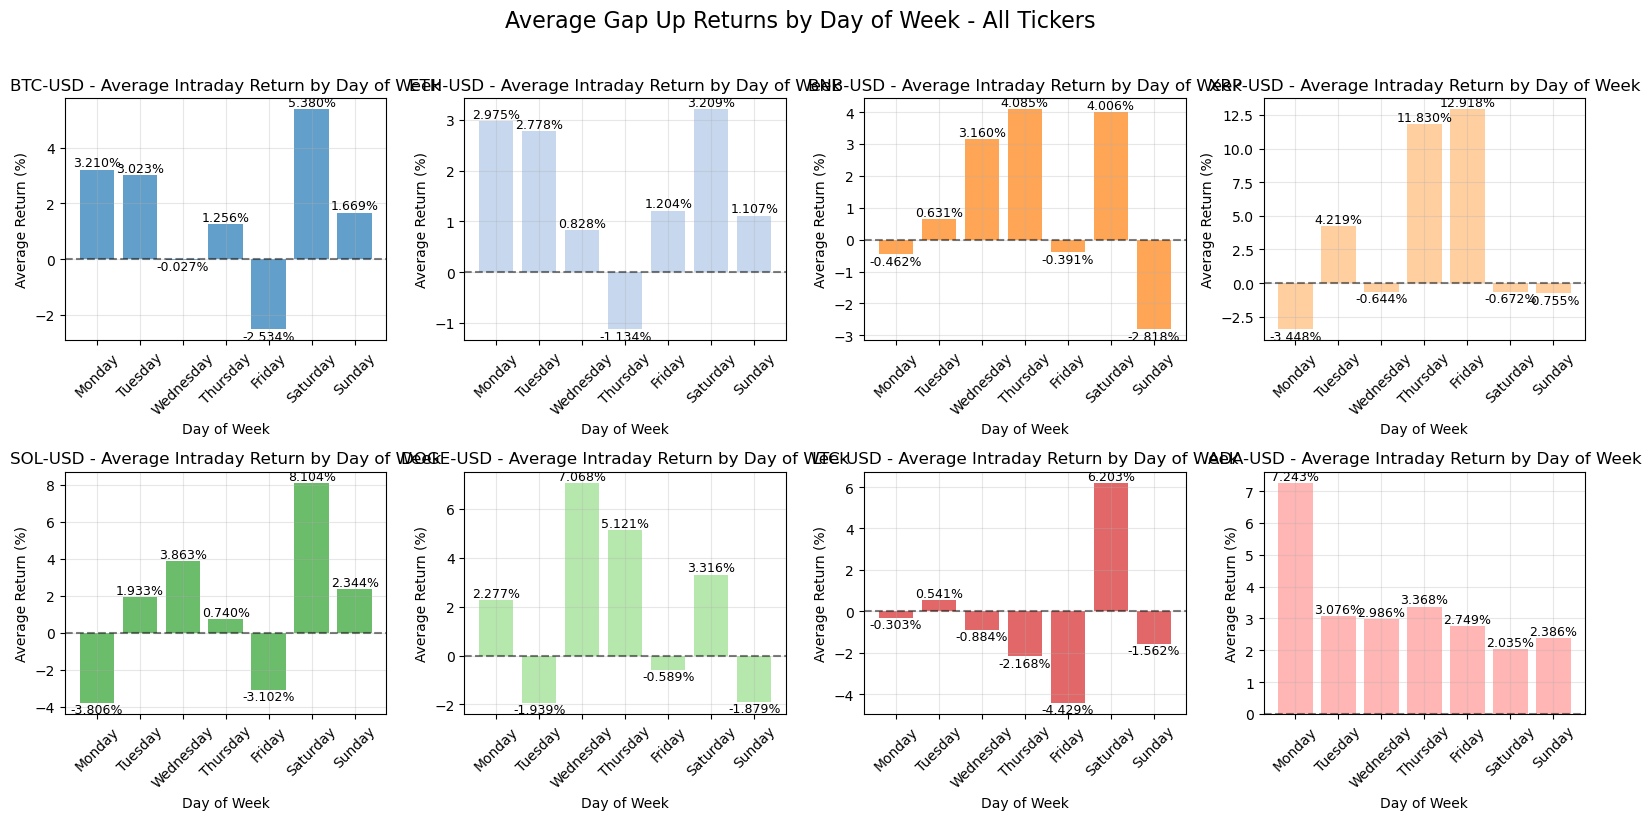

In [12]:
# Plot average returns by day of week for all tickers
n_tickers = len(tickers_)
n_cols = min(4, n_tickers)
n_rows = (n_tickers + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten() if n_tickers > 1 else [axes]

# Generate colors dynamically
colors = plt.cm.tab20(range(n_tickers))

for i, (name, data) in enumerate(tickers_.items()):
    if name in all_results:
        strategy_results = all_results[name]['strategy_results']
        
        axes[i].bar(strategy_results.index, strategy_results['mean'], 
                   color=colors[i], alpha=0.7)
        axes[i].set_title(f"{name} - Average Intraday Return by Day of Week")
        axes[i].set_xlabel("Day of Week")
        axes[i].set_ylabel("Average Return (%)")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].axhline(0, color='black', linestyle='--', alpha=0.5)
        axes[i].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for j, v in enumerate(strategy_results['mean']):
            axes[i].text(j, v + 0.01 if v >= 0 else v - 0.02, f'{v:.3f}%', 
                        ha='center', va='bottom' if v >= 0 else 'top', fontsize=9)

# Hide unused subplots
for i in range(n_tickers, len(axes)):
    axes[i].set_visible(False)

plt.suptitle("Average Gap Up Returns by Day of Week - All Tickers", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

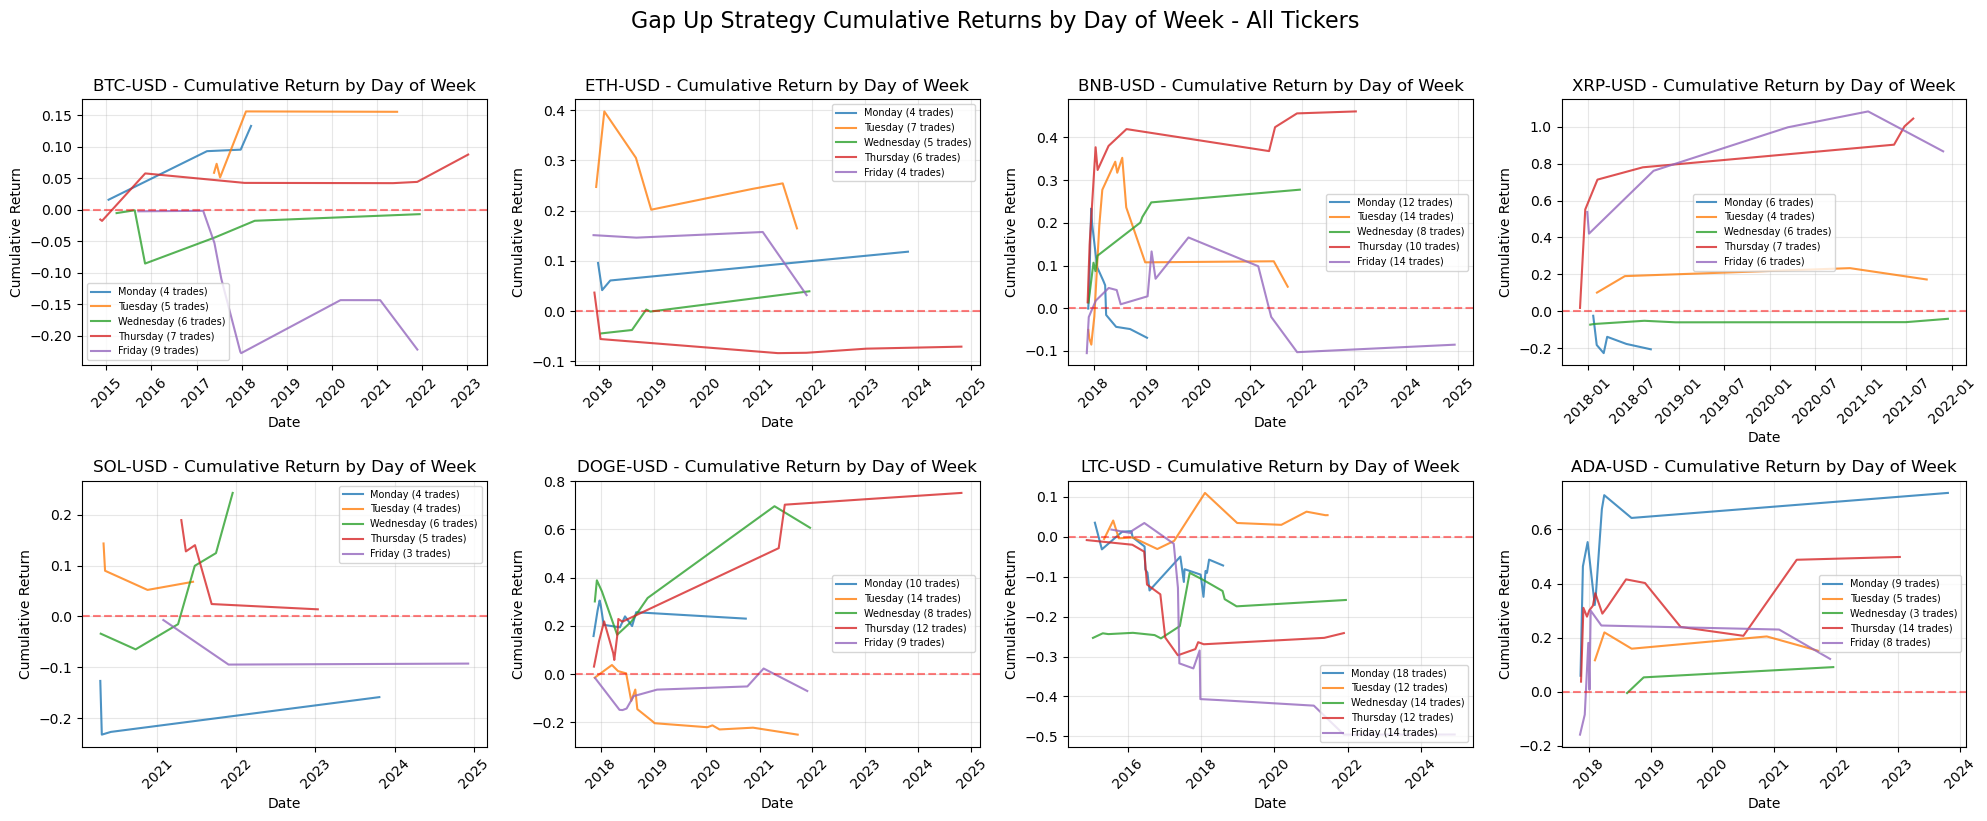

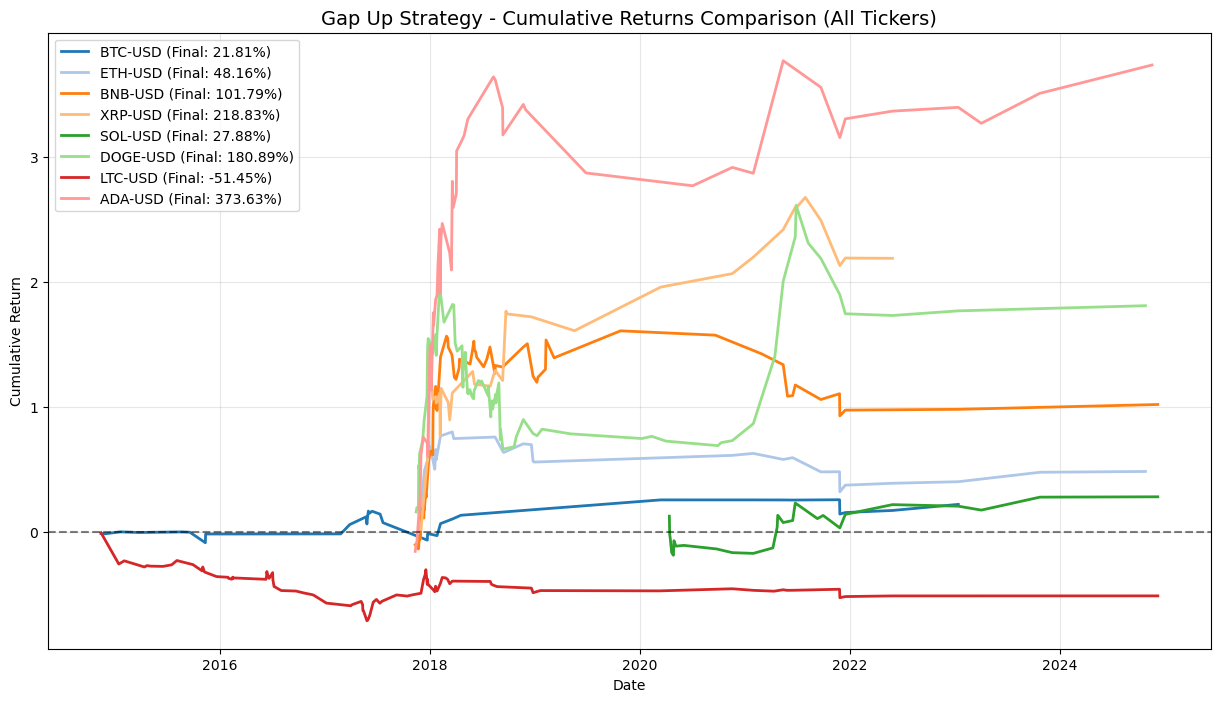

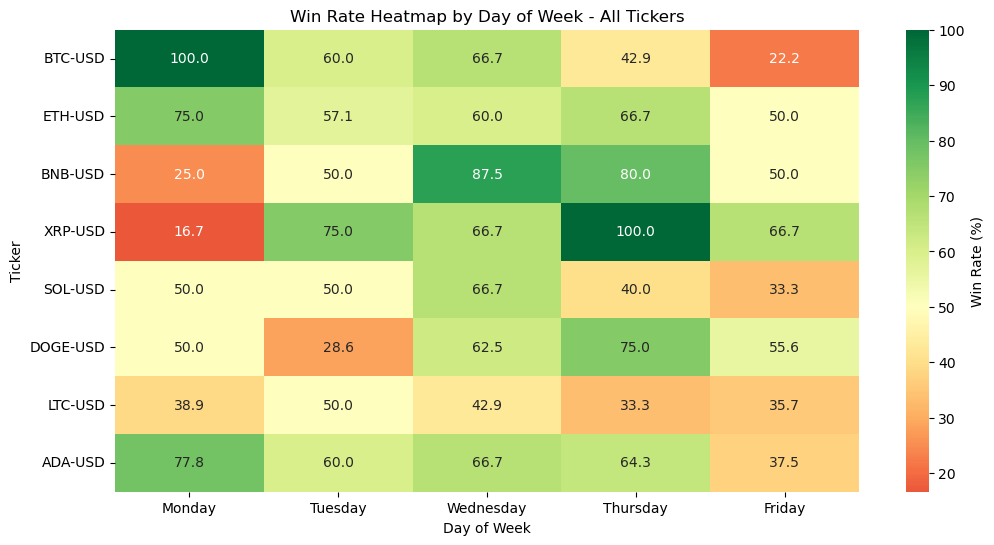

In [13]:
import seaborn as sns

# Cumulative return plots for all tickers
n_tickers = len(tickers_)
n_cols = min(4, n_tickers)
n_rows = (n_tickers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if n_tickers > 1 else [axes]

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = plt.cm.tab20(range(n_tickers))

for i, (name, data) in enumerate(tickers_.items()):
    # Filter for gap up days
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        # Calculate intraday return
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        
        # Plot cumulative return for each day of the week
        for day in range(5):  # Monday to Friday
            day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == day]
            if not day_data.empty:
                day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
                axes[i].plot(day_data.index, day_cumulative, 
                           label=f'{day_names[day]} ({len(day_data)} trades)', 
                           linewidth=1.5, alpha=0.8)
        
        axes[i].set_title(f'{name} - Cumulative Return by Day of Week')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Cumulative Return')
        axes[i].legend(fontsize=7)
        axes[i].grid(True, alpha=0.3)
        axes[i].axhline(0, color='red', linestyle='--', alpha=0.5)
        axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for i in range(n_tickers, len(axes)):
    axes[i].set_visible(False)

plt.suptitle("Gap Up Strategy Cumulative Returns by Day of Week - All Tickers", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Overall cumulative comparison across all tickers
plt.figure(figsize=(15, 8))

for i, (name, data) in enumerate(tickers_.items()):
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        cumulative_return = (1 + gap_up_days_index['intraday_return'] / 100).cumprod() - 1
        
        plt.plot(gap_up_days_index.index, cumulative_return, 
                label=f'{name} (Final: {cumulative_return.iloc[-1]:.2%})', 
                linewidth=2, color=colors[i])

plt.title("Gap Up Strategy - Cumulative Returns Comparison (All Tickers)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.show()

# Win rate comparison heatmap
win_rate_data = []
ticker_list = list(tickers_.keys())
for name in ticker_list:
    if name in all_results:
        win_rates = all_results[name]['win_rates']
        win_rate_data.append([win_rates.get(day, 0) for day in day_names[:5]])

win_rate_df = pd.DataFrame(win_rate_data, 
                          index=ticker_list, 
                          columns=day_names[:5])

plt.figure(figsize=(12, max(6, n_tickers * 0.5)))
sns.heatmap(win_rate_df, annot=True, cmap='RdYlGn', center=50, 
            fmt='.1f', cbar_kws={'label': 'Win Rate (%)'})
plt.title("Win Rate Heatmap by Day of Week - All Tickers")
plt.xlabel("Day of Week")
plt.ylabel("Ticker")
plt.show()

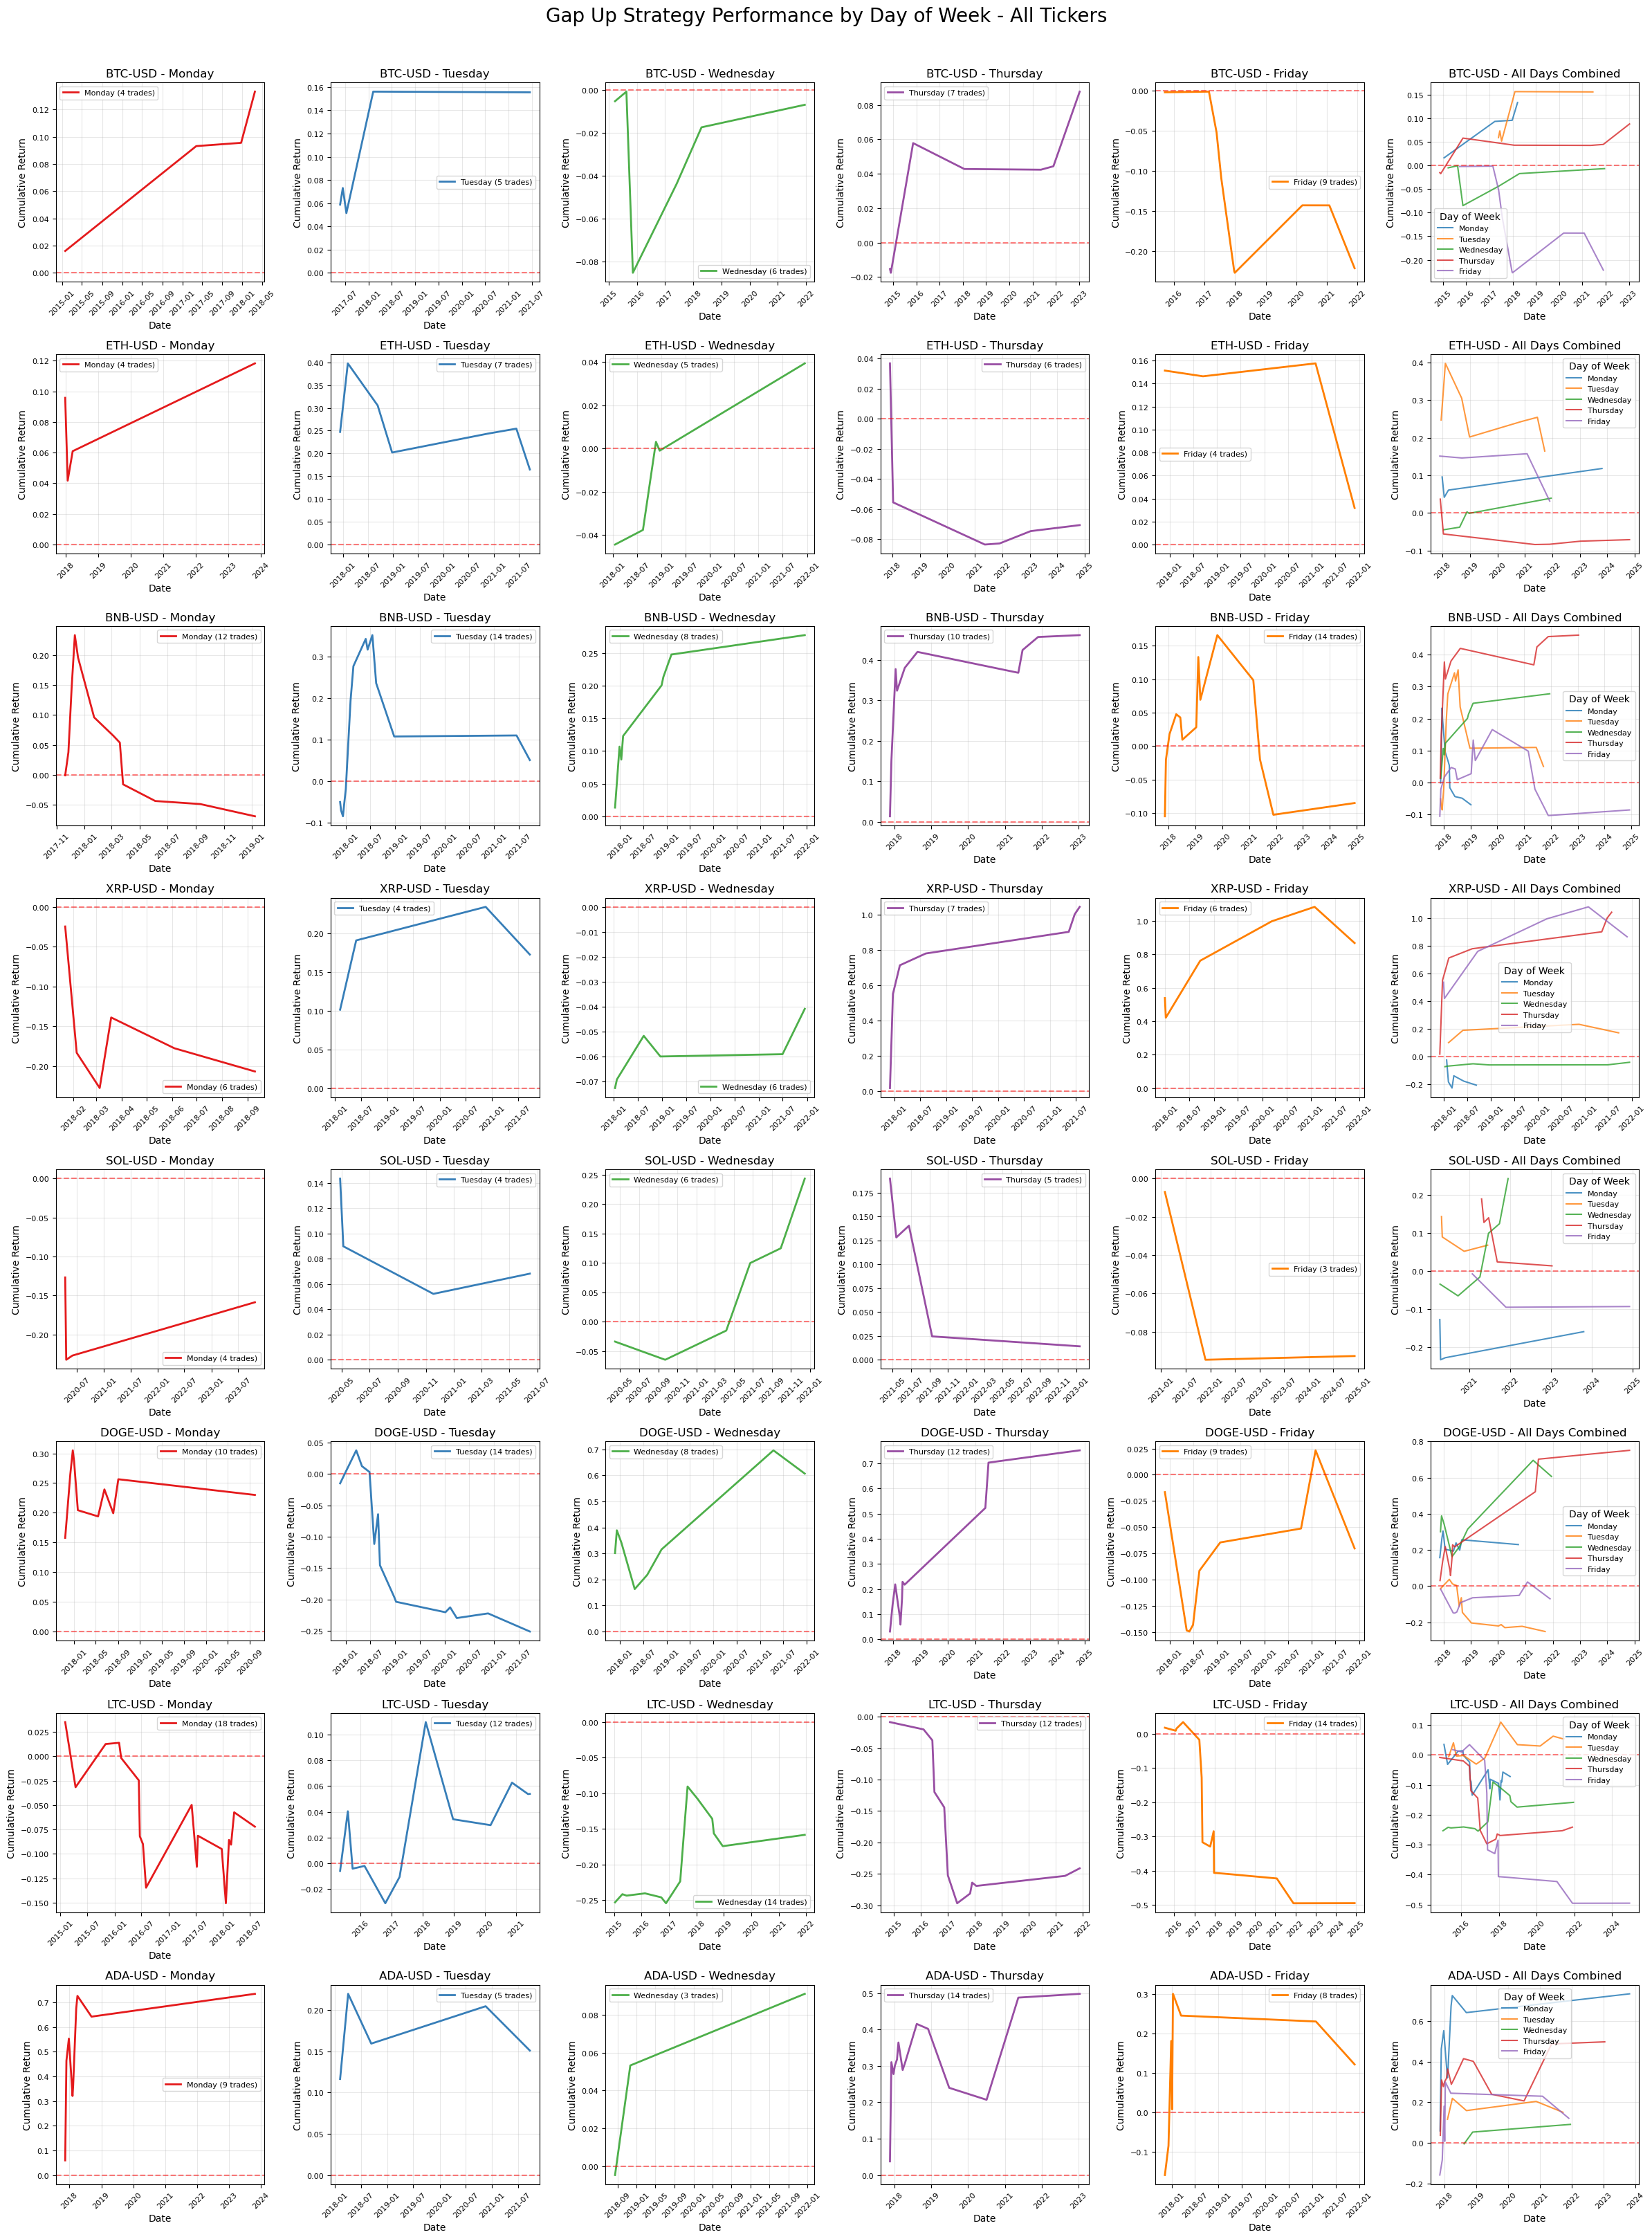


DETAILED PERFORMANCE BY TICKER AND DAY OF WEEK
  Ticker       Day  Trades  Avg_Return_%  Total_Return_%  Win_Rate_%  Best_Return_%  Worst_Return_%  Std_Dev_%
 BTC-USD    Monday       4        3.2099           13.31      100.00         7.5834          0.2193     3.1991
 BTC-USD   Tuesday       5        3.0235           15.55       60.00         9.9585         -2.0160     4.8456
 BTC-USD Wednesday       6       -0.0268           -0.68       66.67         4.5364         -8.4562     4.5009
 BTC-USD  Thursday       7        1.2560            8.77       42.86         7.6646         -1.5302     3.4005
 BTC-USD    Friday       9       -2.5338          -22.16       22.22        10.8787        -12.9966     6.8502
 ETH-USD    Monday       4        2.9748           11.83       75.00         9.5818         -4.9358     6.1484
 ETH-USD   Tuesday       7        2.7780           16.48       57.14        24.7269         -7.9102    12.0625
 ETH-USD Wednesday       5        0.8283            3.95       6

In [ ]:
# Comprehensive day-of-week analysis for each ticker
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Get ticker names dynamically from the dictionary
ticker_list = list(tickers_.keys())
n_tickers = len(ticker_list)

# Create a large figure with subplots for each ticker
# Each ticker gets 6 subplots (5 weekdays + 1 combined)
n_cols = 6
n_rows = n_tickers

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 4*n_tickers))

for idx, (name, data) in enumerate(tickers_.items()):
    # Filter for gap up days for this ticker
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        # Calculate intraday return
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        
        # Create 6 subplots for each ticker (5 weekdays + 1 combined)
        for day in range(6):  # 0-4 for weekdays, 5 for combined
            ax = axes[idx, day] if n_tickers > 1 else axes[day]
            
            if day < 5:  # Individual weekdays
                day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == day]
                if not day_data.empty:
                    # Calculate separate cumulative return for this day only
                    day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
                    
                    ax.plot(day_data.index, day_cumulative, 
                           label=f'{day_names[day]} ({len(day_data)} trades)', 
                           linewidth=2, color=plt.cm.Set1(day))
                    ax.set_title(f'{name} - {day_names[day]}')
                    ax.set_xlabel('Date')
                    ax.set_ylabel('Cumulative Return')
                    ax.legend(fontsize=8)
                    ax.grid(True, alpha=0.3)
                    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
                    
                    # Format x-axis for better readability
                    ax.tick_params(axis='x', rotation=45, labelsize=8)
                    ax.tick_params(axis='y', labelsize=8)
                else:
                    ax.text(0.5, 0.5, f'No {day_names[day]}\ngap-up days', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{name} - {day_names[day]}')
            
            else:  # Combined plot (day == 5)
                ax.set_title(f'{name} - All Days Combined')
                for weekday in range(5):  # Monday to Friday
                    day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == weekday]
                    if not day_data.empty:
                        day_cumulative = (1 + day_data['intraday_return'] / 100).cumprod() - 1
                        ax.plot(day_data.index, day_cumulative, 
                               label=f'{day_names[weekday]}', linewidth=1.5, alpha=0.8)
                
                ax.set_xlabel('Date')
                ax.set_ylabel('Cumulative Return')
                ax.legend(title="Day of Week", fontsize=8)
                ax.grid(True, alpha=0.3)
                ax.axhline(0, color='red', linestyle='--', alpha=0.5)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                ax.tick_params(axis='y', labelsize=8)

plt.suptitle("Gap Up Strategy Performance by Day of Week - All Tickers", fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

# Summary statistics table for each ticker and day combination
print("\n" + "=" * 120)
print("DETAILED PERFORMANCE BY TICKER AND DAY OF WEEK")
print("=" * 120)

summary_table = []
for name, data in tickers_.items():
    gap_up_days_index = data[data['gap_label'] == 1].copy()
    
    if not gap_up_days_index.empty:
        gap_up_days_index['intraday_return'] = ((gap_up_days_index['close'] - gap_up_days_index['open']) / gap_up_days_index['open']) * 100
        
        for day in range(5):  # Monday to Friday
            day_data = gap_up_days_index[gap_up_days_index['day_of_week'] == day]
            if not day_data.empty:
                # Use compounded return instead of sum
                compounded_return = ((1 + day_data['intraday_return'] / 100).prod() - 1) * 100
                day_stats = {
                    'Ticker': name,
                    'Day': day_names[day],
                    'Trades': len(day_data),
                    'Avg_Return_%': round(day_data['intraday_return'].mean(), 4),
                    'Total_Return_%': round(compounded_return, 2),
                    'Win_Rate_%': round((day_data['intraday_return'] > 0).sum() / len(day_data) * 100, 2),
                    'Best_Return_%': round(day_data['intraday_return'].max(), 4),
                    'Worst_Return_%': round(day_data['intraday_return'].min(), 4),
                    'Std_Dev_%': round(day_data['intraday_return'].std(), 4)
                }
                summary_table.append(day_stats)

detailed_df = pd.DataFrame(summary_table)
print(detailed_df.to_string(index=False))

# Find best performing day-ticker combinations
print(f"\n BEST PERFORMING COMBINATIONS:")
print("-" * 60)
best_avg = detailed_df.loc[detailed_df['Avg_Return_%'].idxmax()]
best_total = detailed_df.loc[detailed_df['Total_Return_%'].idxmax()]
best_winrate = detailed_df.loc[detailed_df['Win_Rate_%'].idxmax()]
most_trades = detailed_df.loc[detailed_df['Trades'].idxmax()]

print(f"Best Average Return: {best_avg['Ticker']} on {best_avg['Day']} ({best_avg['Avg_Return_%']}%)")
print(f"Best Total Return: {best_total['Ticker']} on {best_total['Day']} ({best_total['Total_Return_%']}%)")
print(f"Best Win Rate: {best_winrate['Ticker']} on {best_winrate['Day']} ({best_winrate['Win_Rate_%']}%)")
print(f"Most Trading Opportunities: {most_trades['Ticker']} on {most_trades['Day']} ({most_trades['Trades']} trades)")

GAP THRESHOLD OPTIMIZATION
Testing thresholds: [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

Testing gap_threshold = 0.4...
Testing gap_threshold = 0.5...
Testing gap_threshold = 0.6...
Testing gap_threshold = 0.7...
Testing gap_threshold = 0.8...
Testing gap_threshold = 0.9...
Testing gap_threshold = 1.0...
Testing gap_threshold = 1.1...
Testing gap_threshold = 1.2...
Testing gap_threshold = 1.3...
Testing gap_threshold = 1.4...
Testing gap_threshold = 1.5...

OPTIMIZATION RESULTS
 gap_threshold  total_trades  total_return  avg_return_per_trade  avg_win_rate  tickers_analyzed
           0.4           603   5825.419732              1.219923     52.618421                 8
           0.5           426   9490.158121              1.665400     55.080658                 8
           0.6           331  12012.151800              1.866205     56.554367                 8
           0.7           266   2960.026410              1.635606     57.031423                 8
           0

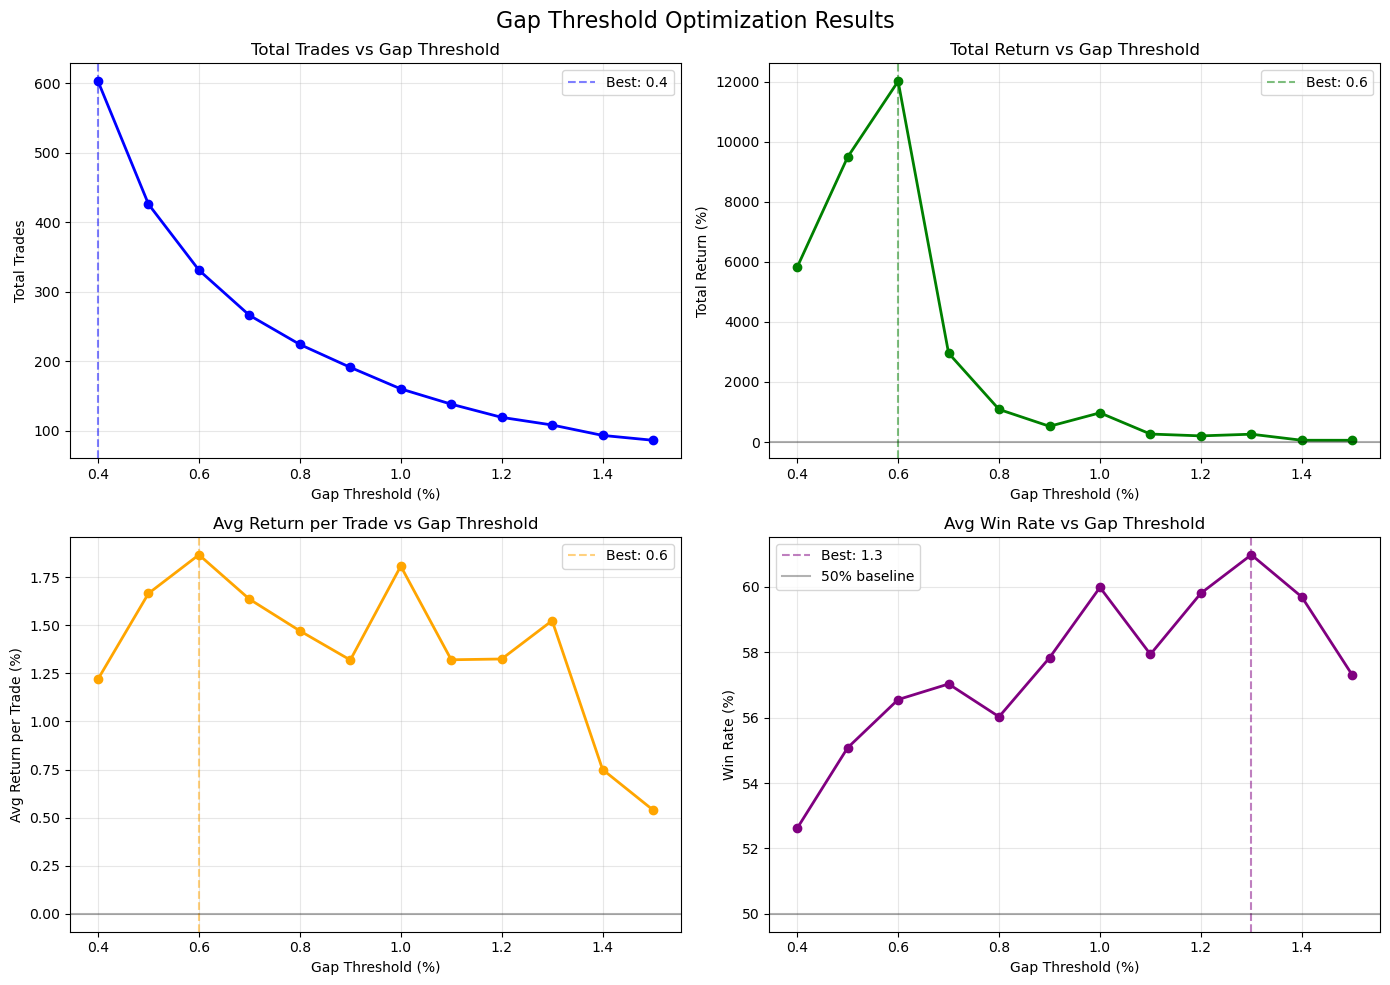


RECOMMENDATION
• Best for Maximum Trades: 0.4 (more signals, lower quality)
• Best for Total Return: 0.6 (highest cumulative profit)
• Best for Avg Return/Trade: 0.6 (best per-trade performance)
• Best for Win Rate: 1.3 (most consistent)

→ Balanced threshold (average): 0.7


In [15]:
# Gap Threshold Optimization
def optimize_gap_threshold(df, tickers, gap_thresholds):
    """
    Optimize gap threshold by testing multiple values and comparing results.
    
    Parameters:
    - df: Original DataFrame with all tickers
    - tickers: List of ticker symbols
    - gap_thresholds: List of threshold values to test
    
    Returns:
    - optimization_results: DataFrame with results for each threshold
    - best_threshold: The optimal threshold based on different metrics
    """
    
    all_optimization_results = []
    
    for threshold in gap_thresholds:
        print(f"Testing gap_threshold = {threshold:.1f}...")
        
        # Prepare data for all tickers with this threshold
        ticker_dfs_temp = {}
        for ticker in tickers:
            ticker_dfs_temp[ticker] = prepare_data(df, ticker, threshold)
        
        # Analyze each ticker
        threshold_results = {
            'gap_threshold': threshold,
            'total_trades': 0,
            'total_return': 0,
            'avg_return_per_trade': [],
            'avg_win_rate': [],
            'tickers_analyzed': 0
        }
        
        ticker_details = []
        
        for name, data in ticker_dfs_temp.items():
            # Filter for gap up days
            gap_up_days = data[data['gap_label'] == 1].copy()
            
            if len(gap_up_days) > 0:
                # Calculate intraday return
                gap_up_days['intraday_return'] = ((gap_up_days['close'] - gap_up_days['open']) / gap_up_days['open']) * 100
                
                # Calculate metrics
                n_trades = len(gap_up_days)
                compounded_return = ((1 + gap_up_days['intraday_return'] / 100).prod() - 1) * 100
                avg_return = gap_up_days['intraday_return'].mean()
                win_rate = (gap_up_days['intraday_return'] > 0).sum() / n_trades * 100
                
                threshold_results['total_trades'] += n_trades
                threshold_results['avg_return_per_trade'].append(avg_return)
                threshold_results['avg_win_rate'].append(win_rate)
                threshold_results['tickers_analyzed'] += 1
                
                ticker_details.append({
                    'ticker': name,
                    'trades': n_trades,
                    'return': compounded_return,
                    'avg_return': avg_return,
                    'win_rate': win_rate
                })
        
        # Calculate aggregate metrics
        if threshold_results['tickers_analyzed'] > 0:
            threshold_results['avg_return_per_trade'] = sum(threshold_results['avg_return_per_trade']) / len(threshold_results['avg_return_per_trade'])
            threshold_results['avg_win_rate'] = sum(threshold_results['avg_win_rate']) / len(threshold_results['avg_win_rate'])
            
            # Calculate total compounded return across all tickers
            total_compounded = 1
            for detail in ticker_details:
                total_compounded *= (1 + detail['return'] / 100)
            threshold_results['total_return'] = (total_compounded - 1) * 100
        else:
            threshold_results['avg_return_per_trade'] = 0
            threshold_results['avg_win_rate'] = 0
        
        all_optimization_results.append(threshold_results)
    
    # Create results DataFrame
    results_df = pd.DataFrame(all_optimization_results)
    
    # Find best thresholds for different metrics
    best_by_trades = results_df.loc[results_df['total_trades'].idxmax(), 'gap_threshold']
    best_by_return = results_df.loc[results_df['total_return'].idxmax(), 'gap_threshold']
    best_by_avg_return = results_df.loc[results_df['avg_return_per_trade'].idxmax(), 'gap_threshold']
    best_by_win_rate = results_df.loc[results_df['avg_win_rate'].idxmax(), 'gap_threshold']
    
    best_thresholds = {
        'most_trades': best_by_trades,
        'best_total_return': best_by_return,
        'best_avg_return': best_by_avg_return,
        'best_win_rate': best_by_win_rate
    }
    
    return results_df, best_thresholds


# Define gap thresholds to test (0.4 to 1.5 in 0.1 increments)
gap_thresholds_to_test = [round(x * 0.1, 1) for x in range(4, 16)]  # [0.4, 0.5, ..., 1.5]

print("=" * 80)
print("GAP THRESHOLD OPTIMIZATION")
print("=" * 80)
print(f"Testing thresholds: {gap_thresholds_to_test}")
print()

# Run optimization
optimization_results, best_thresholds = optimize_gap_threshold(df, tickers, gap_thresholds_to_test)

# Display results
print("\n" + "=" * 80)
print("OPTIMIZATION RESULTS")
print("=" * 80)
print(optimization_results.to_string(index=False))

print("\n" + "=" * 80)
print("BEST THRESHOLDS BY METRIC")
print("=" * 80)
for metric, threshold in best_thresholds.items():
    print(f"{metric}: {threshold}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Total Trades vs Threshold
axes[0, 0].plot(optimization_results['gap_threshold'], optimization_results['total_trades'], 
                marker='o', linewidth=2, color='blue')
axes[0, 0].axvline(best_thresholds['most_trades'], color='blue', linestyle='--', alpha=0.5, 
                   label=f"Best: {best_thresholds['most_trades']}")
axes[0, 0].set_title('Total Trades vs Gap Threshold')
axes[0, 0].set_xlabel('Gap Threshold (%)')
axes[0, 0].set_ylabel('Total Trades')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Total Return vs Threshold
axes[0, 1].plot(optimization_results['gap_threshold'], optimization_results['total_return'], 
                marker='o', linewidth=2, color='green')
axes[0, 1].axvline(best_thresholds['best_total_return'], color='green', linestyle='--', alpha=0.5,
                   label=f"Best: {best_thresholds['best_total_return']}")
axes[0, 1].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].set_title('Total Return vs Gap Threshold')
axes[0, 1].set_xlabel('Gap Threshold (%)')
axes[0, 1].set_ylabel('Total Return (%)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Average Return per Trade vs Threshold
axes[1, 0].plot(optimization_results['gap_threshold'], optimization_results['avg_return_per_trade'], 
                marker='o', linewidth=2, color='orange')
axes[1, 0].axvline(best_thresholds['best_avg_return'], color='orange', linestyle='--', alpha=0.5,
                   label=f"Best: {best_thresholds['best_avg_return']}")
axes[1, 0].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_title('Avg Return per Trade vs Gap Threshold')
axes[1, 0].set_xlabel('Gap Threshold (%)')
axes[1, 0].set_ylabel('Avg Return per Trade (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. Win Rate vs Threshold
axes[1, 1].plot(optimization_results['gap_threshold'], optimization_results['avg_win_rate'], 
                marker='o', linewidth=2, color='purple')
axes[1, 1].axvline(best_thresholds['best_win_rate'], color='purple', linestyle='--', alpha=0.5,
                   label=f"Best: {best_thresholds['best_win_rate']}")
axes[1, 1].axhline(50, color='black', linestyle='-', alpha=0.3, label='50% baseline')
axes[1, 1].set_title('Avg Win Rate vs Gap Threshold')
axes[1, 1].set_xlabel('Gap Threshold (%)')
axes[1, 1].set_ylabel('Win Rate (%)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.suptitle('Gap Threshold Optimization Results', fontsize=16)
plt.tight_layout()
plt.show()

# Summary recommendation
print("\n" + "=" * 80)
print("RECOMMENDATION")
print("=" * 80)
# Find balanced threshold (average of all best thresholds)
balanced_threshold = round(sum(best_thresholds.values()) / len(best_thresholds), 1)
print(f"• Best for Maximum Trades: {best_thresholds['most_trades']} (more signals, lower quality)")
print(f"• Best for Total Return: {best_thresholds['best_total_return']} (highest cumulative profit)")
print(f"• Best for Avg Return/Trade: {best_thresholds['best_avg_return']} (best per-trade performance)")
print(f"• Best for Win Rate: {best_thresholds['best_win_rate']} (most consistent)")
print(f"\n→ Balanced threshold (average): {balanced_threshold}")